### Initial setup

In [12]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

#tuning
from sklearn.model_selection import RandomizedSearchCV

import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

In [13]:
##scoring functions
from sklearn.metrics import r2_score
EPSILON = 1e-10
def _error(actual: np.ndarray, predicted: np.ndarray):
    """Simple error"""
    return actual - predicted
def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)
def mse(actual: np.ndarray, predicted: np.ndarray):
    """Mean Squared Error"""
    return np.mean(np.square(_error(actual, predicted)))
def rmse(actual: np.ndarray, predicted: np.ndarray):
    """Root Mean Squared Error"""
    return np.sqrt(mse(actual, predicted))
def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))
def mae(actual: np.ndarray, predicted: np.ndarray):
    """Mean Absolute Error"""
    return np.mean(np.abs(_error(actual, predicted)))
METRICS = {
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2": r2_score,
}
def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=("mae", "rmse", "mape", "r2")):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

In [14]:
df = pd.read_excel("./calls.xlsx")
df.drop(['INDEX()'],axis=1,inplace=True)
df['Call Date'] = pd.to_datetime(df['Call Date'], format="%d.%m.%Y")
df['Week of Call Date'] = df['Week of Call Date'].str.replace('Week ','').astype(int)

df = df[['Call Date','Month','Year of Call Date','Week of Call Date','Day of Call Date','Weekday of Call Date','Total Incoming Calls']]

#df['Quarter'] = df['Call Date'].dt.quarter
#df['Day of year'] = df['Call Date'].dt.dayofyear

#df = df.groupby(['Call Date','Year of Call Date','Month','Week of Call Date','Day of Call Date','Weekday of Call Date']).sum('Total Incoming Calls')
#df.reset_index(inplace=True)
df

,Call Date,Month,Year of Call Date,Week of Call Date,Day of Call Date,Weekday of Call Date,Total Incoming Calls
0,2020-01-17,1,2020,3,17,6,296
1,2020-01-20,1,2020,4,20,2,381
2,2020-01-21,1,2020,4,21,3,363
3,2020-01-22,1,2020,4,22,4,305
4,2020-01-23,1,2020,4,23,5,304
...,...,...,...,...,...,...,...
482,2021-12-09,12,2021,50,9,5,882
483,2021-12-10,12,2021,50,10,6,792
484,2021-12-13,12,2021,51,13,2,941
485,2021-12-14,12,2021,51,14,3,948


In [8]:
df.dtypes

Call Date               datetime64[ns]
Month                            int64
Year of Call Date                int64
Week of Call Date                int64
Day of Call Date                 int64
Weekday of Call Date             int64
Total Incoming Calls             int64
dtype: object

In [15]:
#Breaking the data and selecting features , predictors
predictors=df.drop(['Total Incoming Calls','Call Date'],axis=1)
target=df['Total Incoming Calls']
x_train,x_cv,y_train,y_cv=train_test_split(predictors,target,test_size=0.2,random_state=42)

#Comparing Algorithms
def scores(i):
    lin = i()
    lin.fit(x_train, y_train)
    y_pred=lin.predict(x_cv)
    lin_r= r2_score(y_cv, y_pred)
    s.append(lin_r)
#Checking the scores by using our function
algos=[LinearRegression,KNeighborsRegressor,
       RandomForestRegressor,Lasso,ElasticNet,DecisionTreeRegressor]
s=[]
for i in algos:
    scores(i)

models = pd.DataFrame({
    'Method': ['LinearRegression', 'KNeighborsRegressor',
               'RandomForestRegressor', 'Lasso','DecisionTreeRegressor'],
    'Score': [s[0],s[1],s[2],s[3],s[4]]})
models.sort_values(by='Score', ascending=False)

,Method,Score
2,RandomForestRegressor,0.847024
1,KNeighborsRegressor,0.728191
0,LinearRegression,0.540051
3,Lasso,0.453211
4,DecisionTreeRegressor,0.435330


In [20]:
resultsDict = {}
predictionsDict = {}

#model = RandomForestRegressor(min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model = RandomForestRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_cv)
#r2_score(y_cv,y_pred)

resultsDict['RandomForest'] = evaluate(y_cv, y_pred)
predictionsDict['RandomForest'] = y_pred
resultsDict['RandomForest']

{'mae': 69.24785714285714,
 'rmse': 102.43368916782512,
 'mape': 0.14674816675068345,
 'r2': 0.8498868766493836}

### XGBoost

In [21]:
#reg = xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, colsample_bylevel=0.5, learning_rate=0.01, random_state=20, n_estimators=1000)
reg = xgb.XGBRegressor(objective='reg:squarederror',subsample=0.5, n_estimators=1000, max_depth=5, learning_rate=0.01, colsample_bytree=0.8, colsample_bylevel=0.8)

reg.fit(x_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
y_pred = reg.predict(x_cv)
#r2_score(y_cv, y_pred)
resultsDict['XGBoost'] = evaluate(y_cv, y_pred)
predictionsDict['XGBoost'] = y_pred
resultsDict['XGBoost']
#reg.feature_importances_

{'mae': 67.39696938650948,
 'rmse': 96.8729414425313,
 'mape': 0.1422266263530368,
 'r2': 0.8657426698526389}

#### XGBoost Tuner
Use computed values from below in above regressor

In [22]:
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
clf.fit(x_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

### LightGBM

In [23]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(x_train, y_train)
y_pred = lightGBM.predict(x_cv)

resultsDict['Lightgbm'] = evaluate(y_cv, y_pred)
predictionsDict['Lightgbm'] = y_pred

#r2_score(y_cv, y_pred)
resultsDict['Lightgbm']

{'mae': 85.59485078951491,
 'rmse': 121.57430276717626,
 'mape': 0.180563846590471,
 'r2': 0.7885456577019125}

In [24]:
test = pd.read_excel('./calls_test.xlsx')
test['Call Date'] = pd.to_datetime(test['Call Date'], format="%d.%m.%Y")
test1=test.drop(['Call Date'],axis=1)
pred2=reg.predict(test1)
test['Total Incoming Calls']=pred2

test

,Call Date,Year of Call Date,Month,Week of Call Date,Day of Call Date,Weekday of Call Date,Total Incoming Calls
0,2021-12-15,2021,12,51,15,4,901.629639
1,2021-12-16,2021,12,51,16,5,822.551636
2,2021-12-17,2021,12,51,17,6,777.045837
3,2021-12-18,2021,12,51,18,7,793.510864
4,2021-12-19,2021,12,51,19,1,958.438171
5,2021-12-20,2021,12,52,20,2,1285.635864
6,2021-12-21,2021,12,52,21,3,1370.397217
7,2021-12-22,2021,12,52,22,4,1267.748657
8,2021-12-23,2021,12,52,23,5,1122.187012
9,2021-12-24,2021,12,52,24,6,986.279846


In [25]:
model.feature_importances_

array([0.01941083, 0.01600323, 0.84203716, 0.0647718 , 0.05777698])

### Ensembling

In [26]:
models = ['RandomForest',
          'Lightgbm',
          'XGBoost']
resis = pd.DataFrame(data={k: y_cv -
                              v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,RandomForest,Lightgbm,XGBoost
RandomForest,1.000000,0.816789,0.902969
Lightgbm,0.816789,1.000000,0.891302
XGBoost,0.902969,0.891302,1.000000


FileNotFoundError: [Errno 2] No such file or directory: 'results/metrics.png'

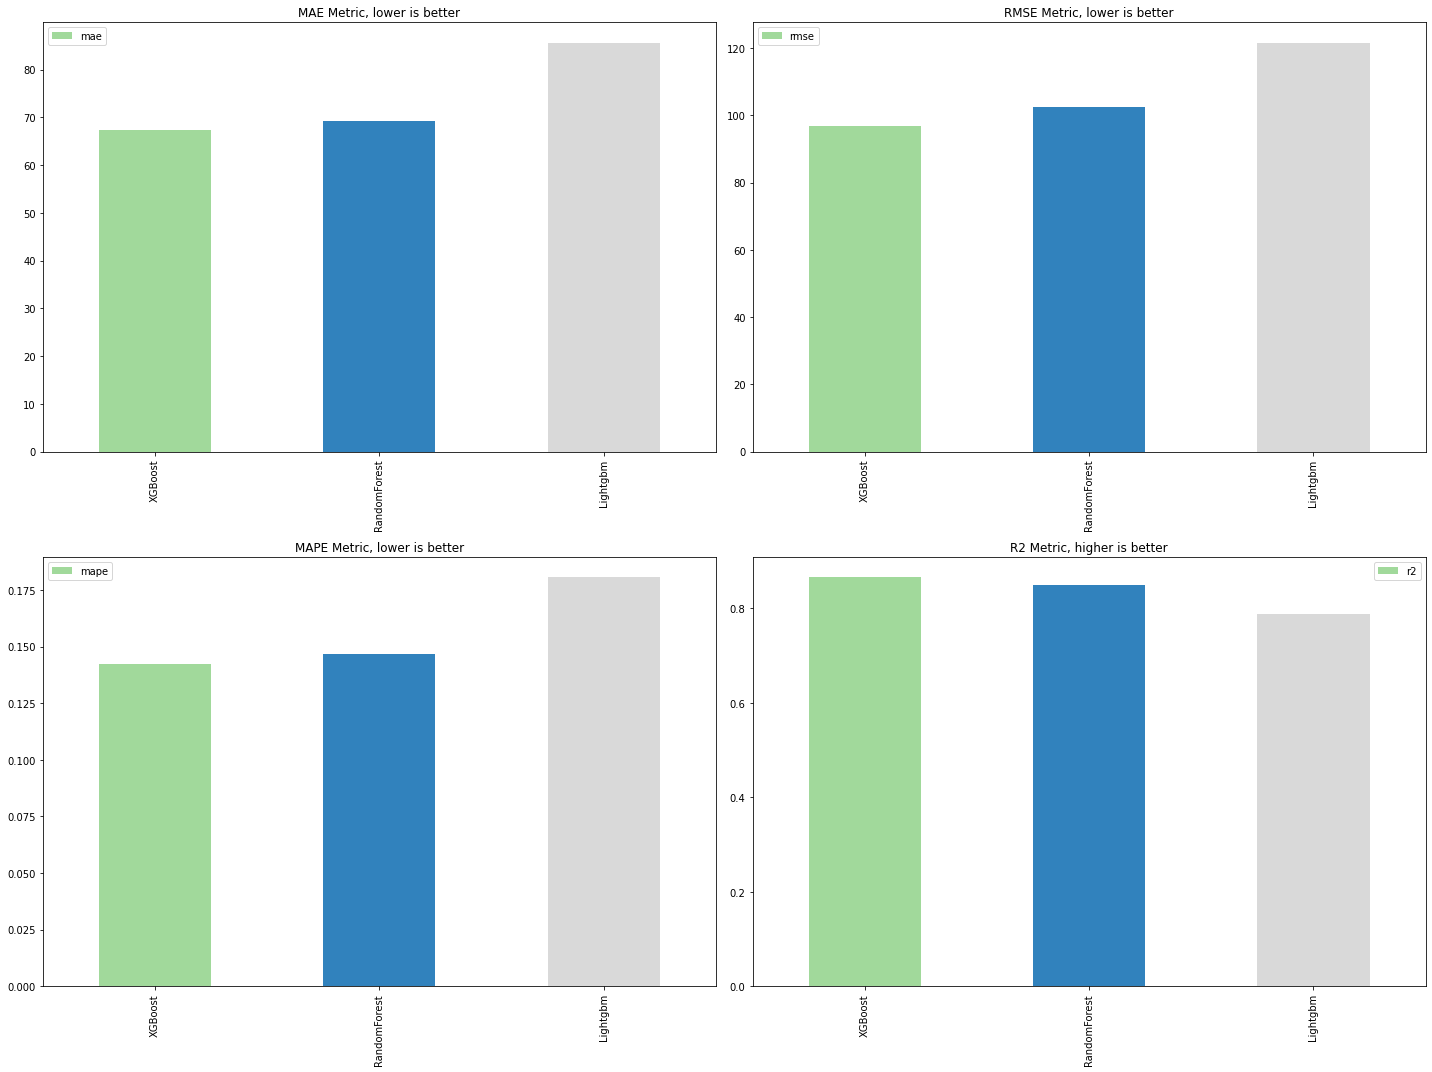

In [29]:
def bar_metrics(resultsDict):
    df = pd.DataFrame.from_dict(resultsDict)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    pallette = plt.cm.get_cmap("tab20c", len(df.columns))
    colors = [pallette(x) for x in range(len(df.columns))]
    color_dict = dict(zip(df.columns, colors))
    fig = plt.figure(figsize=(20, 15))

    # MAE plot
    fig.add_subplot(2, 2, 1)
    df.loc["mae"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[color_dict.get(x, "#333333") for x in df.loc["mae"].sort_values().index],
    )
    plt.legend()
    plt.title("MAE Metric, lower is better")
    fig.add_subplot(2, 2, 2)
    df.loc["rmse"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["rmse"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("RMSE Metric, lower is better")
    fig.add_subplot(2, 2, 3)
    df.loc["mape"].sort_values().plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333") for x in df.loc["mape"].sort_values().index
        ],
    )
    plt.legend()
    plt.title("MAPE Metric, lower is better")
    fig.add_subplot(2, 2, 4)
    df.loc["r2"].sort_values(ascending=False).plot(
        kind="bar",
        colormap="Paired",
        color=[
            color_dict.get(x, "#333333")
            for x in df.loc["r2"].sort_values(ascending=False).index
        ],
    )
    plt.legend()
    plt.title("R2 Metric, higher is better")
    plt.tight_layout()
    plt.savefig("results/metrics.png")
    plt.show()
bar_metrics(resultsDict)